<a href="https://colab.research.google.com/github/owais30/Convolution-Neural-Network/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
!ls

sample_data


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import backend as K

from PIL import Image
import time
import functools

In [0]:
tfe.enable_eager_execution()
print("Eager execution: {}".format(tfe.executing_eagerly()))

Eager execution: True


In [0]:
def load_img(path):
  img = Image.open(path)
  scale = 512 / max(img.size)
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  return img

In [0]:
def im_show(img, title = None):
  if len(img.shape) == 4:
    img = np.squeeze(img, axis = 0)
  img = img.astype('uint8')
  plt.imshow(img)
  if title is not None:
    plt.title(title)
  plt.imshow(img)

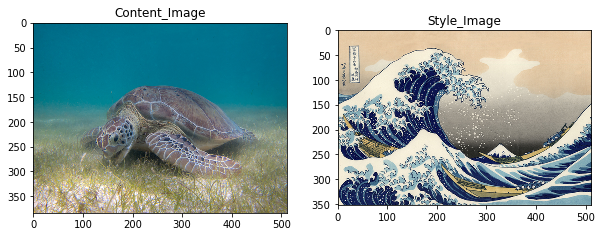

In [0]:


content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

plt.figure(figsize = (10, 10))
content = load_img(content_path)
style = load_img(style_path)
plt.subplot(1,2,1)
im_show(content, "Content_Image")
plt.subplot(1,2,2)
im_show(style, "Style_Image")
plt.show()

# **Prepare Data**

In [0]:
def load_and_prepare_img(img_path):
  img = load_img(img_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def depreprocess(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, axis = 0)
  if len(x.shape) != 3:
    raise ValueError("Invalid Image")
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
content_blocks = ['block5_conv2']

style_blocks = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1'
              ]
num_content_layers = len(content_blocks)
num_style_layers = len(style_blocks)

In [0]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
  vgg.trainable = False
  style_output = [vgg.get_layer(name).output for name in style_blocks]
  content_output = [vgg.get_layer(name).output for name in content_blocks]
  model_outputs = style_output + content_output
  return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, predicted_content):
  return tf.reduce_mean(tf.square(base_content - predicted_content))

In [0]:
def gram_conv(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(gram_target, base_style):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_conv(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [0]:
def compute_loss(model, input_image, loss_weight, gram_style_features, content_features):
  style_weight, content_weight = loss_weight
  model_outputs = model(input_image)
  
  style_output = model_outputs[:num_style_layers]
  content_output = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0
  
  weight_style = 1.0 / float(num_style_layers)
  for target_style, pred_style in zip(gram_style_features, style_output):
    style_score += (get_style_loss(target_style, pred_style[0]) * weight_style)
  
  weight_content = 1.0 / float(num_content_layers)
  for target_content, pred_content in zip(content_features, content_output):
    content_score += (get_content_loss(target_content, pred_content[0]) * weight_content)
  
  style_score *= style_weight  
  content_score *= content_weight
  total_score = style_score + content_score
  
  return total_score, style_score, content_score

In [0]:
def get_target_features(model, content_path, style_path):
  content_img = load_and_prepare_img(content_path)
  style_img = load_and_prepare_img(style_path)
  
  style_output = model(style_img)
  content_output = model(content_img)
  
  style_features = [style_feature[0] for style_feature in style_output[:num_style_layers]]
  content_features = [content_feature[0] for content_feature in content_output[num_style_layers:]]
  
  return style_features, content_features

In [0]:
def gradient(cfg):
  with tf.GradientTape() as tp:
    all_loss = compute_loss(**cfg)
    
  total_loss = all_loss[0]
  return tp.gradient(total_loss, cfg['input_image']), all_loss

In [0]:
import IPython.display as display
def style_transfer(content_path, style_path, iterations = 1000, content_weight = 1e3, style_weight = 1e-2):
  loss_weight = [style_weight, content_weight]
  
  model = get_model()
  for layer in model.layers:
    layer.trainable = False
  
  style_features, content_features = get_target_features(model, content_path, style_path)
  gram_style_features = [gram_conv(style_feature) for style_feature in style_features] 
  
  input_image = load_and_prepare_img(content_path)
  input_image = tfe.Variable(input_image, dtype=tf.float32)
  
  cfg = {
      'model': model,
      'input_image': input_image,
      'loss_weight': loss_weight,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  
  optimizer = tf.train.AdamOptimizer(learning_rate = 5, beta1 = 0.99, epsilon = 1e-1)
  
  
  best_img, best_loss = None, float('inf')
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means  
  
  start_time = time.time()
  global_start = start_time
  display_interval = 100
  
  images = []
  
  for i in range(iterations):
    grad, all_losses = gradient(cfg)
    optimizer.apply_gradients([(grad, input_image)])
    total_loss, style_loss, content_loss = all_losses
    clipped = tf.clip_by_value(input_image, min_vals, max_vals)
    input_image.assign(clipped)
    end_time = time.time()
    
    if best_loss > total_loss:
      best_loss = total_loss
      best_img = depreprocess(input_image.numpy())
    
    if i % display_interval == 0:
      
      
      img = input_image.numpy()
      img = depreprocess(img)
      images.append(img)
      display.clear_output(wait=True)
      print("Iteration: {}\ntotal_loss: {:.4e} content_loss: {:.4e} style_loss: {:.4e} time: {:.4f}".format(i, total_loss, content_loss, style_loss, (time.time()- start_time))) 
      img = Image.fromarray(img)
      display.display_png(img)
      start_time = time.time()
      
  print("Total time: {:.4f}".format(time.time()-global_start))
  display.clear_output(wait=True)
  
  plt.figure(figsize = (14,4))
  for i, img in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
  
  return best_img, best_loss

In [0]:
def show_images(content_path, style_path, best_image):
  plt.figure(figsize = (10, 10))
  content = load_img(content_path)
  style = load_img(style_path)
  plt.subplot(1,3,1)
  im_show(content, "Content_Image")
  plt.subplot(1,3,2)
  im_show(style, "Style_Image")
  plt.subplot(1,3,3)
  im_show(best_image, "Best_Image")
  plt.show()

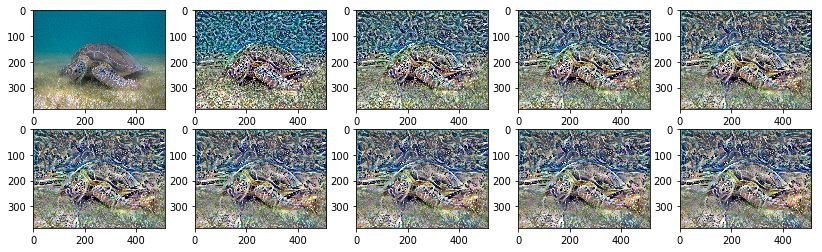

In [0]:
best_img, best_loss = style_transfer(content_path, style_path)

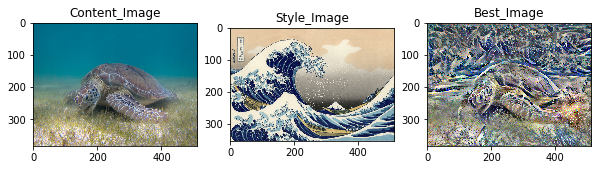

In [0]:

show_images('/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg','/tmp/nst/The_Great_Wave_off_Kanagawa.jpg', best_img )

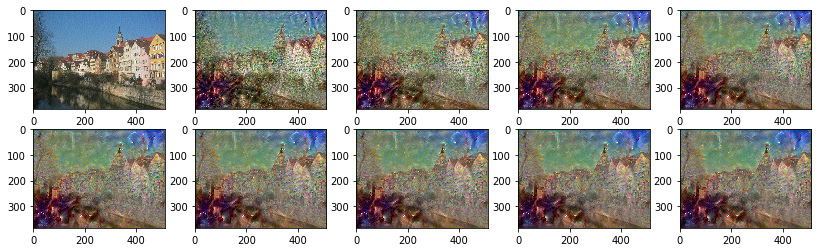

In [0]:
best_poc_tubingen, best_loss = style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg', 
                                                  '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

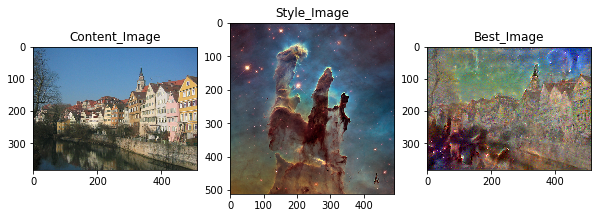

In [0]:
show_images('/tmp/nst/Tuebingen_Neckarfront.jpg', '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg', best_poc_tubingen)

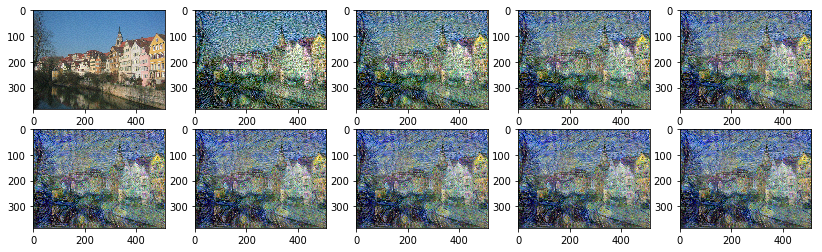

In [0]:
best_starry_night, best_loss = style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg',
                                                  '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

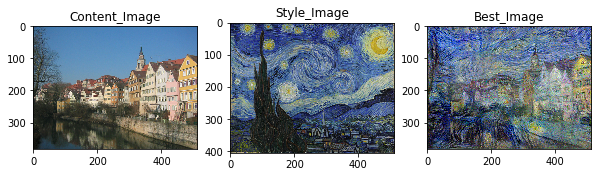

In [0]:
show_images('/tmp/nst/Tuebingen_Neckarfront.jpg','/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg', best_starry_night)